In [2]:
import pandas as pd

df = pd.read_csv("../data_text/processed/isot_text_processed.csv")

print(df.shape)
print(df.columns)
print(df["label"].value_counts())
df.head()


(44889, 2)
Index(['clean_text', 'label'], dtype='object')
label
1    23472
0    21417
Name: count, dtype: int64


,clean_text,label
0,as u s budget fight looms republicans flip the...,0
1,u s military to accept transgender recruits on...,0
2,senior u s republican senator let mr mueller d...,0
3,fbi russia probe helped by australian diplomat...,0
4,trump wants postal service to charge much more...,0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        max_features=50000,
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", LogisticRegression(max_iter=2000))
])

model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9900868790376476
              precision    recall  f1-score   support

           0      0.989     0.990     0.990      4283
           1      0.991     0.990     0.991      4695

    accuracy                          0.990      8978
   macro avg      0.990     0.990     0.990      8978
weighted avg      0.990     0.990     0.990      8978

Confusion matrix:
 [[4242   41]
 [  48 4647]]


In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

y_proba = model.predict_proba(X_test)[:, 1]

def eval_threshold(thresh: float):
    y_pred_t = (y_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    return {
        "threshold": thresh,
        "accuracy": accuracy_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t, zero_division=0),
        "recall": recall_score(y_test, y_pred_t, zero_division=0),
        "f1": f1_score(y_test, y_pred_t, zero_division=0),
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }

thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)
results = pd.DataFrame([eval_threshold(t) for t in thresholds])
results


,threshold,accuracy,precision,recall,f1,TP,FP,TN,FN
0,0.1,0.899755,0.839506,0.999361,0.912485,4692,897,3386,3
1,0.2,0.962575,0.934770,0.998083,0.965389,4686,327,3956,9
2,0.3,0.982736,0.971150,0.996592,0.983707,4679,139,4144,16
3,0.4,0.988305,0.983769,0.994036,0.988876,4667,77,4206,28
4,0.5,0.990087,0.991254,0.989776,0.990515,4647,41,4242,48
5,0.6,0.987191,0.996101,0.979340,0.987649,4598,18,4265,97
6,0.7,0.978726,0.997790,0.961448,0.979282,4514,10,4273,181
7,0.8,0.960125,0.998620,0.925027,0.960416,4343,6,4277,352
8,0.9,0.903876,1.000000,0.816187,0.898792,3832,0,4283,863


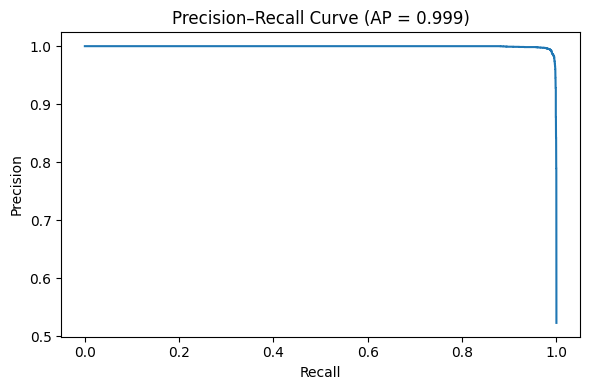

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import os

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

os.makedirs("../outputs/text", exist_ok=True)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (AP = {ap:.3f})")
plt.tight_layout()
plt.savefig("../outputs/text/pr_curve.png", dpi=200)
plt.show()


In [7]:
import numpy as np
import pandas as pd

tfidf = model.named_steps["tfidf"]
clf = model.named_steps["clf"]

feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_[0]

coef_df = pd.DataFrame({
    "word": feature_names,
    "coefficient": coefs,
    "odds_ratio": np.exp(coefs)
}).sort_values("coefficient", ascending=False)

coef_df.head(20)      # words pushing toward FAKE
coef_df.tail(20)      # words pushing toward REAL


,word,coefficient,odds_ratio
7640,comment,-3.029611,4.833443e-02
41021,spokesman,-3.086575,4.565806e-02
44400,told reuters,-3.159087,4.246449e-02
10586,democratic,-3.188980,4.121387e-02
37984,said statement,-3.233021,3.943818e-02
32725,presidential,-3.374470,3.423624e-02
28514,nov,-3.590369,2.758815e-02
26854,monday,-3.881243,2.062518e-02
26522,minister,-3.967926,1.891261e-02
16071,friday,-3.990775,1.848538e-02


Conclusion: 
The text only TF-IDF model achieves higher precision and recall than the metadata models, indicating that linguistic content is highly predictive of misinformation in this dataset. However, performance may reflect dataset specific writing patterns, motivating the use of hybrid models and robustness checks.